### name: Chunsheng Fang
### github name: chunshengFang
### usc id :5043794779

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

#  3. Time Series Classification

## 3(a). Download the AReM dataset

In [2]:
data_root = "./data/AReM"

actvt_dirs = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
orig_columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
data_root

'./data/AReM'

## 3(b). Divide dataset into training and test sets.

In [3]:
# function to traverse data folder and split file paths in to train group and test group
def split_train_test(root):
    train_files = []
    test_files = []
    for root, _, file in os.walk(data_root):
        for f in file:
            if (os.path.splitext(f)[1] == ".csv"):
                csv_idx = int(re.findall("\d+", f)[0])
                file_path = os.path.join(root, f)
                activity = os.path.split(root)[-1]
                if (csv_idx <= 2 or (activity not in ["bending1", "bending2"] and csv_idx == 3)):
                    test_files.append(file_path)
                else:
                    train_files.append(file_path)
    return train_files, test_files

In [4]:
# split instances
train_files, test_files = split_train_test(data_root)

In [5]:
train_files

['./data/AReM\\bending1\\dataset3.csv',
 './data/AReM\\bending1\\dataset4.csv',
 './data/AReM\\bending1\\dataset5.csv',
 './data/AReM\\bending1\\dataset6.csv',
 './data/AReM\\bending1\\dataset7.csv',
 './data/AReM\\bending2\\dataset3.csv',
 './data/AReM\\bending2\\dataset4.csv',
 './data/AReM\\bending2\\dataset5.csv',
 './data/AReM\\bending2\\dataset6.csv',
 './data/AReM\\cycling\\dataset10.csv',
 './data/AReM\\cycling\\dataset11.csv',
 './data/AReM\\cycling\\dataset12.csv',
 './data/AReM\\cycling\\dataset13.csv',
 './data/AReM\\cycling\\dataset14.csv',
 './data/AReM\\cycling\\dataset15.csv',
 './data/AReM\\cycling\\dataset4.csv',
 './data/AReM\\cycling\\dataset5.csv',
 './data/AReM\\cycling\\dataset6.csv',
 './data/AReM\\cycling\\dataset7.csv',
 './data/AReM\\cycling\\dataset8.csv',
 './data/AReM\\cycling\\dataset9.csv',
 './data/AReM\\lying\\dataset10.csv',
 './data/AReM\\lying\\dataset11.csv',
 './data/AReM\\lying\\dataset12.csv',
 './data/AReM\\lying\\dataset13.csv',
 './data/AReM\

In [6]:
test_files

['./data/AReM\\bending1\\dataset1.csv',
 './data/AReM\\bending1\\dataset2.csv',
 './data/AReM\\bending2\\dataset1.csv',
 './data/AReM\\bending2\\dataset2.csv',
 './data/AReM\\cycling\\dataset1.csv',
 './data/AReM\\cycling\\dataset2.csv',
 './data/AReM\\cycling\\dataset3.csv',
 './data/AReM\\lying\\dataset1.csv',
 './data/AReM\\lying\\dataset2.csv',
 './data/AReM\\lying\\dataset3.csv',
 './data/AReM\\sitting\\dataset1.csv',
 './data/AReM\\sitting\\dataset2.csv',
 './data/AReM\\sitting\\dataset3.csv',
 './data/AReM\\standing\\dataset1.csv',
 './data/AReM\\standing\\dataset2.csv',
 './data/AReM\\standing\\dataset3.csv',
 './data/AReM\\walking\\dataset1.csv',
 './data/AReM\\walking\\dataset2.csv',
 './data/AReM\\walking\\dataset3.csv']

# 3(c). Feature Extraction

### 3(c)-i. Research what types of time-domain features are usually used in time series classification


### 3(c)-ii. Extract the time-domain features minimum, maximum, mean, median, stan-dard deviation, first quartile, and third quartile for all of the 6 time series in each instance.

In [7]:
def load_data(files, feature, orig_columns, segs=1, standard=False):
    import csv
    sniffer = csv.Sniffer()
    
    # generate columns of describes and label with indecies
    describe_order = ['mean', 'std', 'min', '_1stquart_', 'median', '_3rdquart_','max']
    desc_order_idx = [desc + str(i) for i in range(1, 6 * segs + 1) for desc in describe_order]
    
    instances  = []
    labels = []
    for csv in files:
        # get the label of the instance read from current csv
        parent_folder = os.path.dirname(csv)
        activity = os.path.split(parent_folder)[-1]
        labels.append(activity)
        
        # identidy the separater of the csv file
        sep = sniffer.sniff(open(csv).read()).delimiter
        
        # error_bad_lines=False used to 
        if sep == ",":
            cur_instance = pd.read_csv(csv, skiprows=5, header=None, 
                                       error_bad_lines=False, warn_bad_lines=False)
        else:
            cur_instance = pd.read_csv(csv, skiprows=5, header=None, sep="\s+", 
                                       error_bad_lines=False, warn_bad_lines=False)
        
        # restore the column of csv file as we skip 5th row which is headers in the csv
        # however, they will becomes mass when separater is space. Thus, skip it
        cur_instance.columns = orig_columns
        
        # break 6 time series into equal length, becomes 6*segs series
        seg_length = int(cur_instance.shape[0] / segs)
        segs_describe = []
        for i in range(segs):
            cur_seg = cur_instance[i * seg_length : min((i + 1) * seg_length, cur_instance.shape[0])]
            cur_describe = cur_seg.describe().drop('count').drop(columns="# Columns: time").T
            segs_describe.append(cur_describe.values.flatten())
        # complete current instance reading
        instances.append(np.concatenate(segs_describe, axis=None))
    
    # convert to dataframe and reorder the columns based on given feature list
    feature_df = pd.DataFrame(instances, columns=desc_order_idx)
    feature_df = feature_df.loc[:, feature]
    
    if standard:
        feature_df = feature_df.apply(lambda col: (col-col.mean()) / (np.std(col) + 1e-9), axis = 0)
    
    # add label to complete the dataset
    feature_df['label'] = pd.Series(labels)
    
    return feature_df


In [8]:
# reorder the columns
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 7) for stat in statistics]

# load dataset as required
train_data=pd.DataFrame()
test_data=pd.DataFrame()
train_data = load_data(train_files, feature, orig_columns)
test_data = load_data(test_files, feature, orig_columns)
new_dataset=pd.concat([train_data,test_data])

C:\Users\Fcs10\AppData\Local\Temp\ipykernel_2028\3128110510.py:22: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cur_instance = pd.read_csv(csv, skiprows=5, header=None,
C:\Users\Fcs10\AppData\Local\Temp\ipykernel_2028\3128110510.py:22: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cur_instance = pd.read_csv(csv, skiprows=5, header=None,
C:\Users\Fcs10\AppData\Local\Temp\ipykernel_2028\3128110510.py:22: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cur_instance = pd.read_csv(csv, skiprows=5, header=None,
C:\Users\Fcs10\AppData\Local\Temp\ipykernel_2028\3128110510.py:22: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


 

In [9]:
new_dataset

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.500,0.0,1.79,0.493292,0.430,0.513506,0.000,0.940,bending1
1,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.330,0.0,2.18,0.613521,0.500,0.524317,0.000,1.000,bending1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.250,0.0,1.79,0.383292,0.430,0.389164,0.000,0.500,bending1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.000,0.0,5.26,0.679646,0.500,0.622534,0.430,0.870,bending1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.750,0.0,2.96,0.555313,0.490,0.487826,0.000,0.830,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,35.50,46.25,43.174938,43.670,1.989052,42.50,44.5000,0.0,2.12,0.506583,...,12.7500,16.500,0.0,5.72,0.911979,0.830,0.666161,0.470,1.220,standing
15,32.75,47.00,42.760563,44.500,3.398919,41.33,45.3725,0.0,3.34,0.486167,...,13.0000,18.565,0.0,5.73,0.842271,0.710,0.722165,0.430,1.090,standing
16,19.33,43.50,34.227771,35.500,4.889576,30.50,37.7500,0.0,14.50,3.995729,...,14.7500,18.670,0.0,9.74,3.394125,3.100,1.792090,2.105,4.425,walking
17,12.50,45.00,33.509729,34.125,4.850923,30.50,36.7500,0.0,13.05,4.450771,...,14.6275,18.750,0.0,8.96,3.378479,3.085,1.787360,2.060,4.440,walking


In [10]:
train_data

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1
1,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,bending1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555313,0.490,0.487826,0.00,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking
65,21.50,51.00,34.935813,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking
66,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking


In [11]:
test_data

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
3,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
4,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
5,28.75,44.75,37.561188,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080688,...,18.0000,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770,cycling
6,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,16.0000,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150,cycling
7,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363688,...,5.5000,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000,lying
8,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940,lying
9,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830,lying


## 3(c)-iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Build a 90% bootsrap confidence interval for the standard deviation of each feature

In [12]:
# Estimate the standard deviation
train_data.describe().loc['std']

min1           8.794295
max1           4.429182
mean1          4.948702
median1        5.008023
std1           1.742288
_1stquart_1    5.761289
_3rdquart_1    4.776417
min2           0.000000
max2           5.147841
mean2          1.600310
median2        1.436960
std2           0.902411
_1stquart_2    0.952201
_3rdquart_2    2.159405
min3           3.030200
max3           4.759853
mean3          3.866981
median3        3.843579
std3           0.956182
_1stquart_3    4.147699
_3rdquart_3    3.925659
min4           0.000000
max4           2.302408
mean4          1.179383
median4        1.150092
std4           0.473508
_1stquart_4    0.839419
_3rdquart_4    1.565779
min5           5.368786
max5           5.449726
mean5          5.114993
median5        5.271503
std5           1.038686
_1stquart_5    5.525521
_3rdquart_5    4.973035
min6           0.051766
max6           2.540166
mean6          1.170853
median6        1.104626
std6           0.520300
_1stquart_6    0.774358
_3rdquart_6    1

In [13]:
from sklearn.utils import resample
def bootStrap(data, num_resample, operation, low=5, upper=95):
    # a list to keep all resample results
    estimation = []
    for i in range(num_resample):
        # resample the data with replacement, keep the same size of resampled data
        resampled = resample(data, replace=True, n_samples=data.shape[0])
        # get the relative statistic metric based on given operation
        estimation.append(resampled.apply(lambda col : operation(col, ddof=1), axis=0))
    # convert list to data frame and get 5%-95% percentile
    estimation = pd.DataFrame(estimation, columns=list(data.columns))
    interval = estimation.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
    return interval.apply(np.around, args=(2,))

In [15]:
_90_intervals = bootStrap(train_data.iloc[:, :-1], 1000, np.std)
_90_intervals

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,std5,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6
0,7.58,3.26,4.34,4.31,1.54,5.17,3.95,0.0,4.67,1.40,...,0.77,3.98,3.58,0.00,2.22,1.06,0.99,0.48,0.69,1.40
1,10.11,5.37,5.48,5.59,1.90,6.27,5.50,0.0,5.53,1.74,...,1.26,6.79,6.08,0.09,2.82,1.24,1.17,0.55,0.83,1.64


## 3(c)-iv Use your judgement to select the three most important time-domain features

In [16]:
bending_binary_train = pd.DataFrame(train_data)
bending_binary_train.loc[bending_binary_train['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_binary_train.loc[bending_binary_train['label'] != 1, 'label'] = 0
#bending_binary_train.loc[bending_binary_train['label'] == 0, '_1stquart_2']
bending_binary_train

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,1
1,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555313,0.490,0.487826,0.00,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,0
65,21.50,51.00,34.935813,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,0
66,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,0
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,0


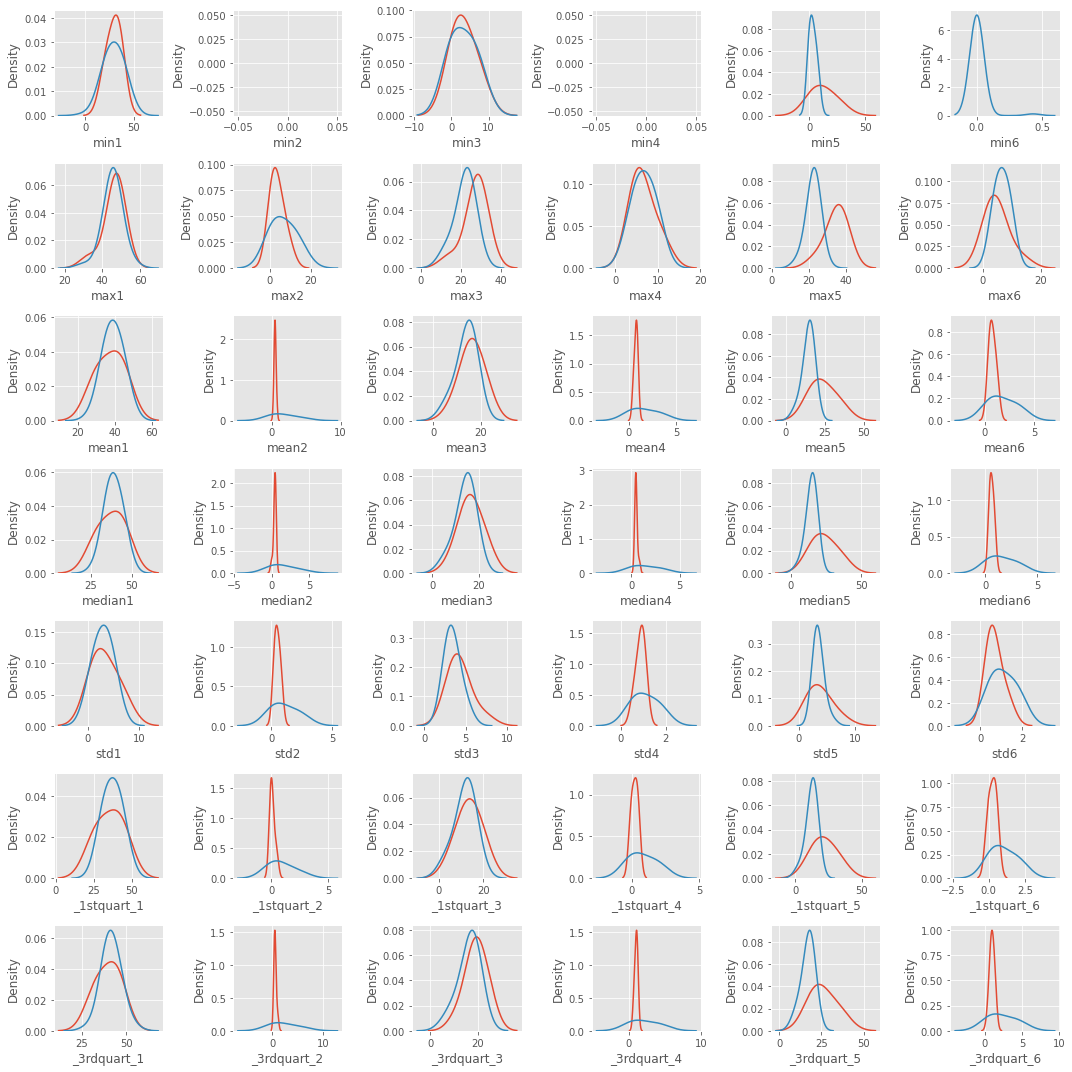

In [17]:
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(7, 6, figsize=(15, 15))
for i in range(1, 7):
    for j, f in enumerate(statistics):
        sns.distplot(bending_binary_train.loc[bending_binary_train['label'] == 1, f + str(i)], 
                     kde = True, 
                     hist = False,
                     ax = axes[j, i-1],
                     label='Bending',
                     kde_kws={'bw' : -1.})
        sns.distplot(bending_binary_train.loc[bending_binary_train['label'] == 0, f + str(i)], 
                    kde = True, 
                     hist = False,
                     ax = axes[j, i-1],
                     label='Not Bending',
                     kde_kws={'bw' : -1.})

plt.tight_layout()
plt.show()


Based on the principle to relatively clear seperated distributions, I choose max, mean and 75% as the top 3.

## 3(c)-v. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [18]:
# function to get pair plot for given series number and selected features
def pairplot(data, series_nums, select_features):
    selected_features = [f + str(i) for i in series_nums for f in select_features]
    selected_data = data[selected_features + ['label']]
    sns.pairplot(selected_data, hue='label')
    plt.show()

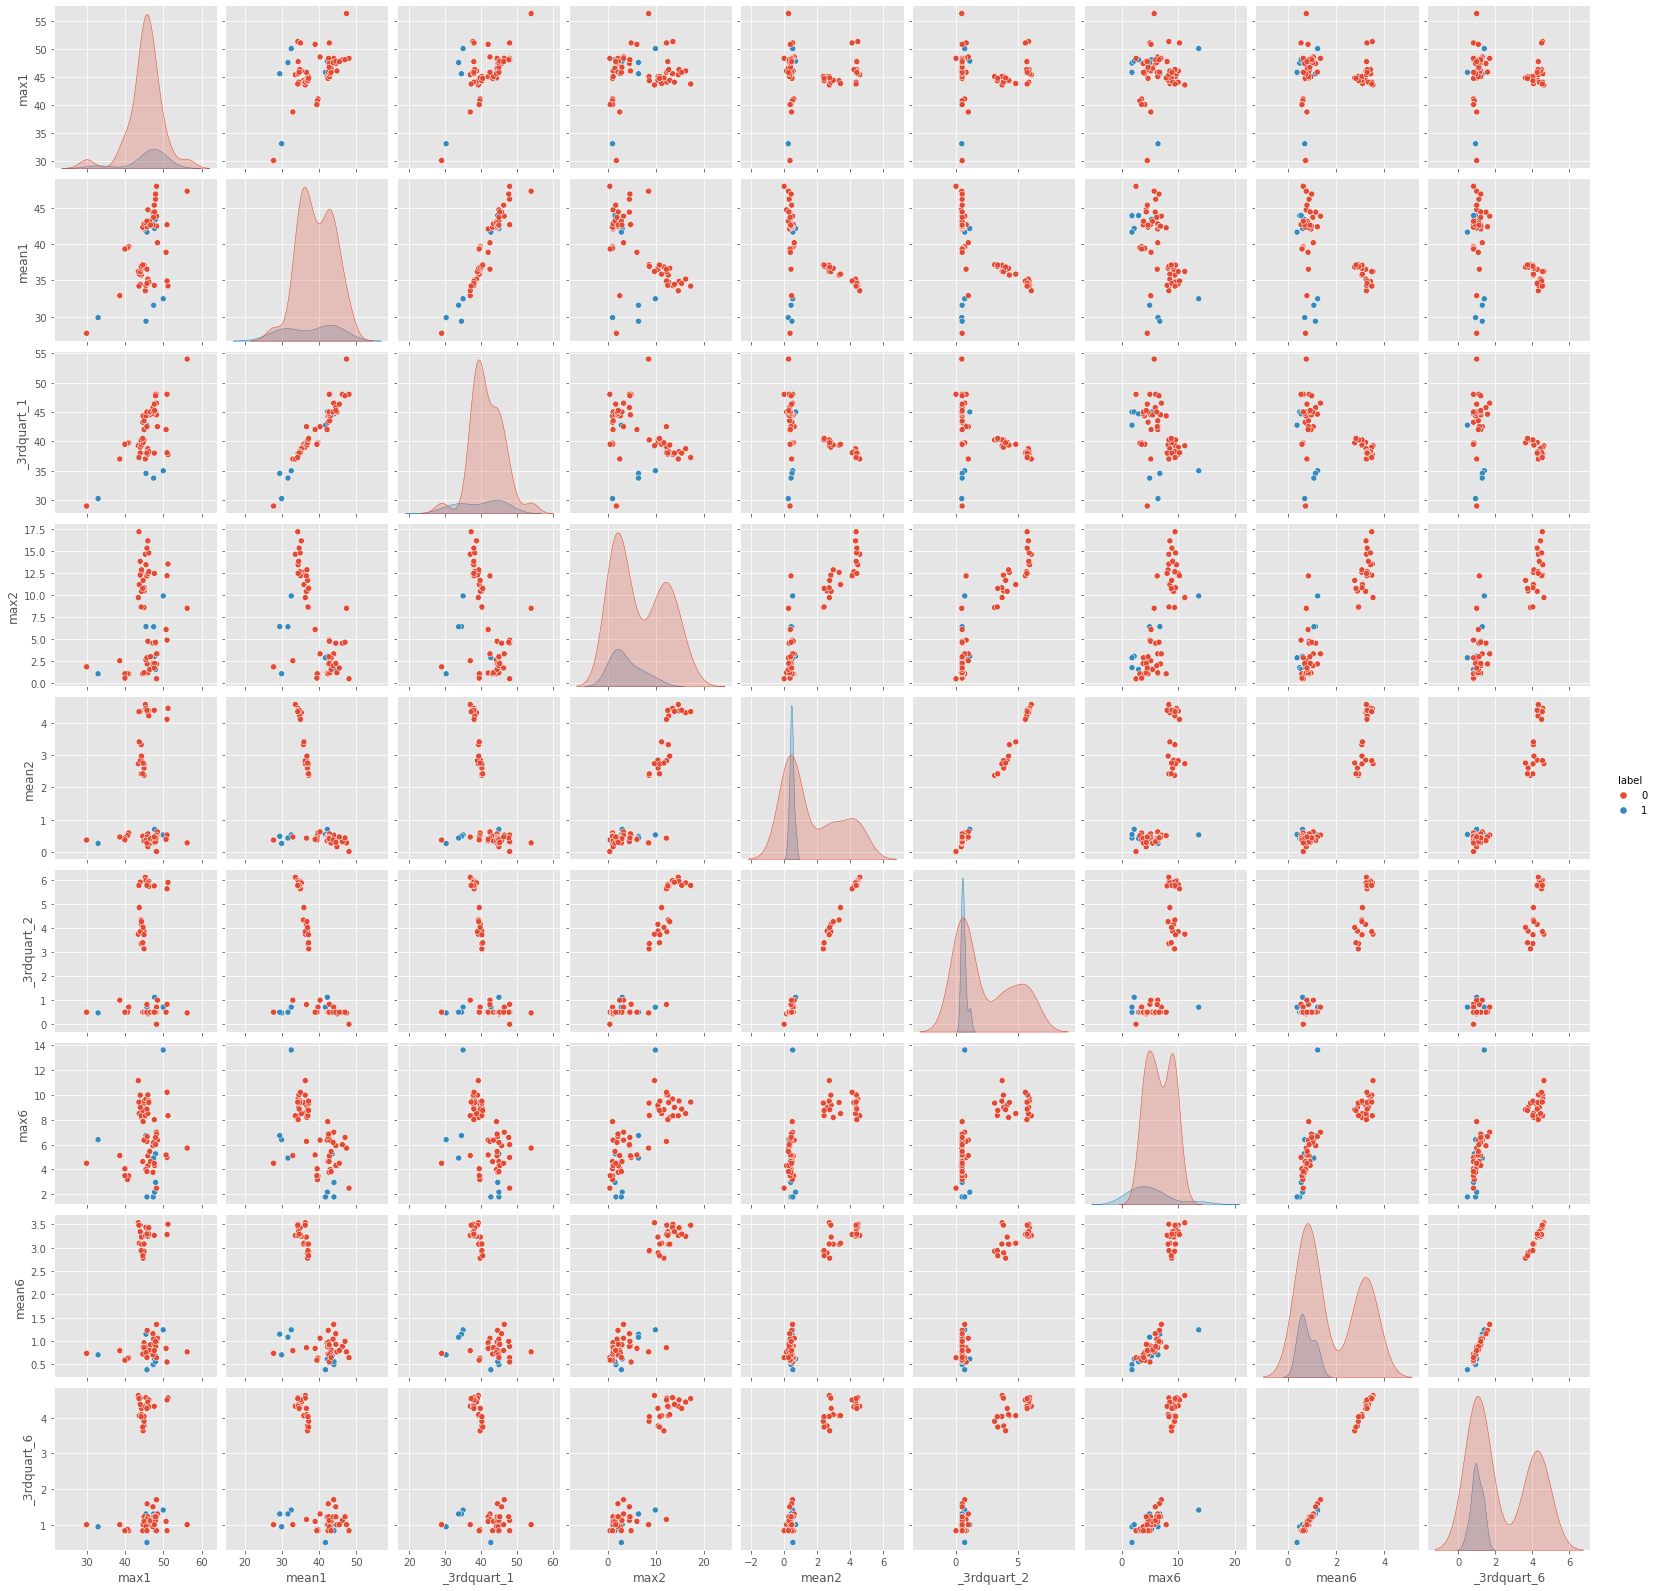

In [19]:
# Select the ['max', 'mean', '_3rdquart_'] of 1, 2 and 6 time series
pairplot(bending_binary_train, [1, 2, 6], ['max', 'mean', '_3rdquart_'])


## 4(a)-i Break each time series in your training set into two (approximately) equal length time series.

In [20]:
# reorder the columns
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 13) for stat in statistics]

# load dataset as required: break each time series into 2 folds
train_data_2fold = load_data(train_files, feature, orig_columns, segs=2)
test_data_2fold = load_data(test_files, feature, orig_columns, segs=2)

In [21]:
bending_binary_train_2fold = pd.DataFrame(train_data_2fold)
bending_binary_train_2fold.loc[bending_binary_train_2fold['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_binary_train_2fold.loc[bending_binary_train_2fold['label'] != 1, 'label'] = 0
#bending_binary_train.loc[bending_binary_train['label'] == 0, '_1stquart_2']
bending_binary_train_2fold

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_11,_3rdquart_11,min12,max12,mean12,median12,std12,_1stquart_12,_3rdquart_12,label
0,36.50,46.50,44.057167,44.500,1.556971,43.2500,45.0000,0.0,1.50,0.381042,...,33.0000,36.2500,0.00,1.50,0.388333,0.000,0.478528,0.0000,0.7100,1
1,33.75,47.75,43.278875,45.000,3.473355,42.0000,45.2500,0.0,3.00,0.673292,...,28.7500,33.7500,0.00,2.18,0.586083,0.470,0.491873,0.0000,0.8700,1
2,33.00,45.75,41.621208,42.330,3.118644,39.6525,44.2500,0.0,2.83,0.623083,...,28.3100,30.5625,0.00,1.50,0.347500,0.430,0.363144,0.0000,0.5000,1
3,39.00,48.00,44.117042,45.000,1.359836,43.5000,45.0000,0.0,1.30,0.250042,...,22.5000,23.7500,0.00,4.06,0.543875,0.500,0.473445,0.4300,0.7100,1
4,36.67,45.00,43.486208,43.710,1.281976,42.3300,44.5000,0.0,1.30,0.378667,...,21.0000,23.5000,0.00,2.96,0.585750,0.500,0.487918,0.4225,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,22.33,46.00,34.966250,35.500,4.733014,32.0000,38.7500,0.0,12.68,4.207958,...,14.0000,18.5000,0.00,9.39,3.430208,3.350,1.647979,2.1700,4.4400,0
65,21.50,45.67,34.737042,35.500,4.276717,32.0000,37.7500,0.0,12.21,4.217333,...,14.5000,18.2500,0.00,10.21,3.225917,3.085,1.665326,2.0500,4.3500,0
66,18.33,45.00,33.886458,34.375,5.143776,30.4575,37.5000,0.0,12.44,4.332208,...,13.6275,18.2500,0.00,8.01,3.274750,2.955,1.670593,2.0500,4.4375,0
67,18.33,44.00,34.836458,35.750,4.869092,32.0000,38.6900,0.0,12.38,4.257750,...,13.9375,18.2500,0.47,8.84,3.409458,3.110,1.707089,2.1700,4.3450,0


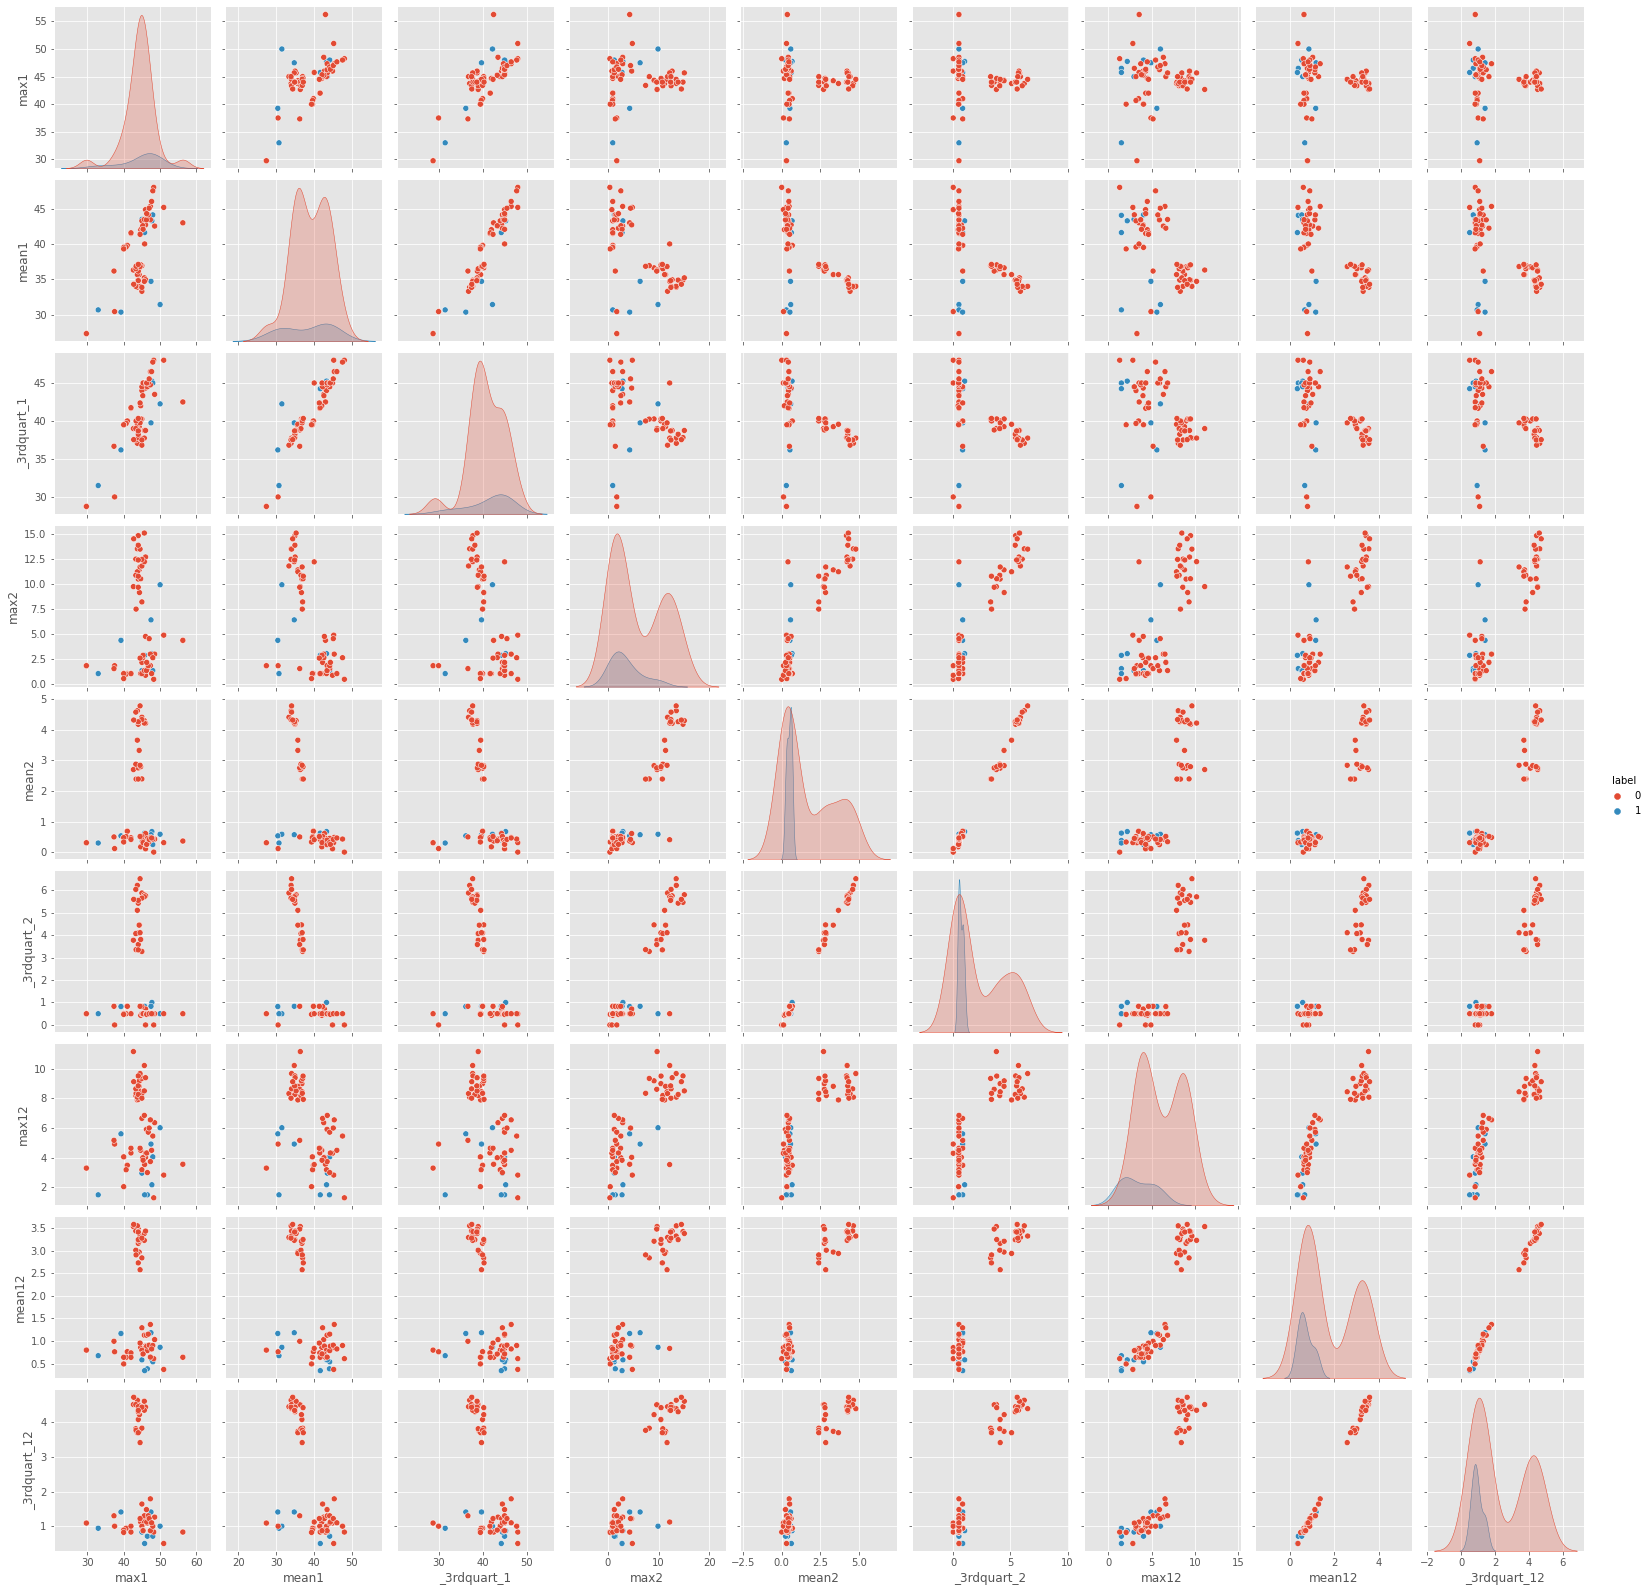

In [22]:
# Select the ['max', 'mean', '_3rdquart_'] of 1, 2 and 12 time series
pairplot(bending_binary_train_2fold, [1, 2, 12], ['max', 'mean', '_3rdquart_'])

By comparing two plots, we can see that the distributions are slightly different but look similar for the first sight.

## 4(a)-ii Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features.

In [38]:
# import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# perform logistic regression and cross validation for a given value of l
def logisticRegressionCV(train_files, test_files, num_fold, l, penalty, oversample):
    # specify columns
    orig_columns = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
    feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
    
    # load data with given value of l
    train_set = load_data(train_files, feature, orig_columns, segs=l)
    train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
    train_set.loc[train_set['label'] != "1", 'label'] = "0"
    #print(train_set)
    #test_set = load_data(test_files, feature, orig_columns, segs=l)
    
    # oversample the data if required
    if oversample:
        num_label_0 = train_set.loc[train_set['label'] == "0"].shape[0]
        num_label_1 = train_set.loc[train_set['label'] == "1"].shape[0]
        minor_count = min(num_label_0, num_label_1)
        major_count = max(num_label_0, num_label_1)
        minor_label = "1" if num_label_0 > num_label_1 else "0"
        minor = train_set.loc[train_set['label'] == minor_label]
        major = train_set.loc[train_set['label'] != minor_label]
        minor = resample(minor, replace=True, random_state=60,
                         n_samples=max(num_label_0, num_label_1))
        train_set = pd.concat([major, minor])
        print("Oversample the minority from {} to {} samples".format(minor_count, 
                                                                     major_count))
    
    # split features and labels
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    #print(trainX.shape)
    #testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # create 5-fold cross validator, logistic regression classifier and featrue selector
    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    validator = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    
    # return the feature selector
    return model, selector

# interate values of l from 1 to 20
def iterateL(train_files,test_files, num_fold, L, penalty='none', oversample=False):
    best_p = []
    score = []
    
    for l in range(1, L + 1):
        classifier, selector = logisticRegressionCV(train_files, test_files, 
                                                    num_fold, l, penalty=penalty,
                                                    oversample=oversample)
        best_p.append(selector.n_features_)
        score.append(selector.grid_scores_)
        print("Pair",(l, best_p[-1]))
        print("Scores",np.max(selector.grid_scores_))

In [40]:
iterateL(train_files,test_files, 5, 20)

Pair (1, 6)
Scores 1.0
Pair (2, 7)
Scores 1.0
Pair (3, 8)
Scores 1.0
Pair (4, 28)
Scores 1.0
Pair (5, 8)
Scores 1.0
Pair (6, 17)
Scores 1.0
Pair (7, 35)
Scores 1.0
Pair (8, 10)
Scores 1.0
Pair (9, 18)
Scores 1.0
Pair (10, 11)
Scores 1.0
Pair (11, 8)
Scores 1.0
Pair (12, 12)
Scores 1.0
Pair (13, 4)
Scores 1.0
Pair (14, 15)
Scores 1.0
Pair (15, 13)
Scores 1.0
Pair (16, 11)
Scores 1.0
Pair (17, 5)
Scores 1.0
Pair (18, 11)
Scores 1.0
Pair (19, 8)
Scores 1.0
Pair (20, 5)
Scores 1.0


## 4(a)-iii. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression B’s as well as the p-values associated with them.


In [41]:
# fit model with l = 1
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in statistics]

# get the selected feature
classifier, selector = logisticRegressionCV(train_files, test_files, 5, 1, 
                                            penalty='none', oversample=False)
selected_feature = [f for i, f in enumerate(feature) if selector.support_[i]]

selected_feature

['_3rdquart_1', 'max2', 'min5', 'max5', 'mean5', '_1stquart_5']

In [42]:
# use statmodels package here to get p-values
import statsmodels.api as sm
import statsmodels.formula.api as smf

train_set = load_data(train_files, feature, orig_columns, segs=1)
train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[train_set['label'] != 1, 'label'] = 0
trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]

# build model, remember to add constant to features
trainX_const = sm.add_constant(trainX.loc[:, selected_feature].to_numpy(dtype=float))
#print(trainY.to_numpy())
model = sm.Logit(trainY.to_numpy(dtype=float), trainX_const)
#logitres = model.fit_regularized()
logitres = model.fit(method='bfgs')

print(logitres.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Tue, 05 Jul 2022   Pseudo R-squ.:                   1.000
Time:                        00:20:56   Log-Likelihood:            -1.1857e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8424   9.75e+07  -8.6

[[60  0]
 [ 0  9]]


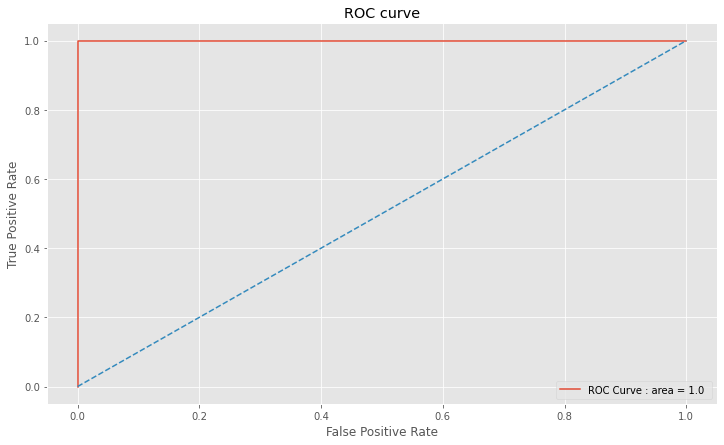

In [43]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# predictY = logitres.predict(trainX_const)
# fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype=float), predictY, pos_label=1)
# print(trainY.to_numpy(dtype=float))
# print(type(predictY[0]))

classifier.fit(trainX.loc[:, selected_feature], trainY.to_numpy(dtype="int"))
predictY = classifier.predict(trainX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(trainX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(trainY.to_numpy(dtype=float), predictY.round())
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

## 4(a)-iv Test the classifier on the test set

[[15  0]
 [ 0  4]]


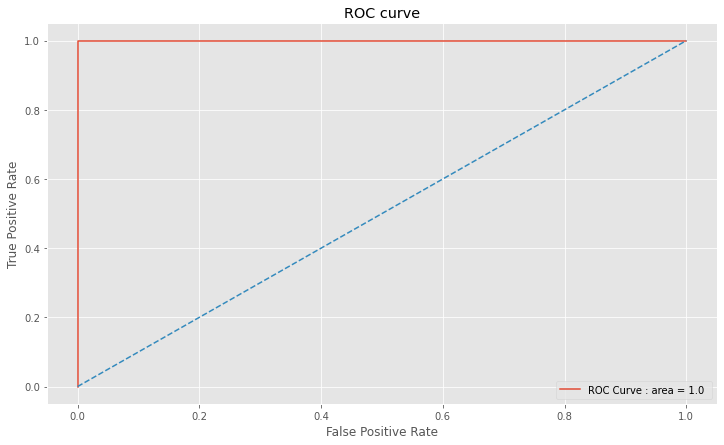

In [44]:
test_set = load_data(test_files, feature, orig_columns, segs=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# predictY = logitres.predict(testX_const)
# testX_const = sm.add_constant(testX.loc[:, selected_feature].to_numpy(dtype=float))

# make predict use the model kept by RFECV
predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

# create confusion matrix
conf_mat = confusion_matrix(testY.astype(int), predictY.astype(int))
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

In my experiment, the test accuracy is as good as the cross validation accuracy. Both are all correct.

## 4(a)-v Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes. The summary of statmodels has following statement

Complete Separation: The results show that there is complete separation. In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.

## 4(a)-vi From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.


Yes. From confusion matrix, we can see that the number of non-bending class (label 0：60 ) has significantly more sample than bending class (label 1：9 ).

In [45]:
iterateL(train_files, test_files, 5, 20, oversample=True)

Oversample the minority from 9 to 60 samples
Pair (1, 5)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (2, 2)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (3, 115)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (4, 4)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (5, 2)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (6, 4)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (7, 2)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (8, 3)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (9, 5)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (10, 6)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (11, 7)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (12, 7)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (13, 4)
Scores 1.0
Oversample the minority from 9 to 60 samples
Pair (14, 3)
Scores 1.0
Oversample the minority from 9 to 60 samp

In [46]:
# fit model with l = 1
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in statistics]

# get the selected feature
classifier, selector = logisticRegressionCV(train_files, test_files, 5, 1, 
                                            penalty='none', oversample=True)
selected_feature = [f for i, f in enumerate(feature) if selector.support_[i]]

selected_feature

Oversample the minority from 9 to 60 samples


['_3rdquart_1', 'min5', 'max5', '_1stquart_5', 'max6']

Oversample the minority from 9 to 60 samples
[[60  0]
 [ 0 60]]


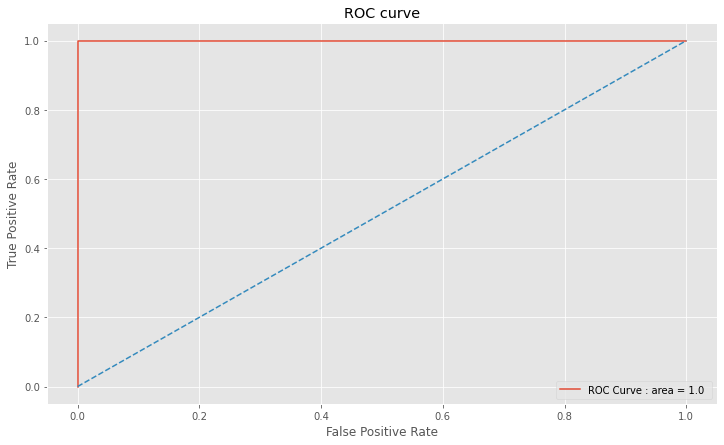

In [47]:
# load original data
train_set = load_data(train_files, feature, orig_columns, segs=1)
train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[train_set['label'] != 1, 'label'] = 0

# oversample
num_label_0 = train_set.loc[train_set['label'] == 0].shape[0]
num_label_1 = train_set.loc[train_set['label'] == 1].shape[0]
minor_count = min(num_label_0, num_label_1)
major_count = max(num_label_0, num_label_1)
minor_label = 1 if num_label_0 > num_label_1 else 0
minor = train_set.loc[train_set['label'] == minor_label]
major = train_set.loc[train_set['label'] != minor_label]
minor = resample(minor, replace=True, 
                         n_samples=max(num_label_0, num_label_1))
train_set = pd.concat([major, minor])
print("Oversample the minority from {} to {} samples".format(minor_count, 
                                                            major_count))

trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]

classifier.fit(trainX.loc[:, selected_feature], trainY.to_numpy(dtype="int"))
predictY = classifier.predict(trainX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(trainX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(trainY.to_numpy(dtype=float), predictY.round())
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

[[15  0]
 [ 0  4]]


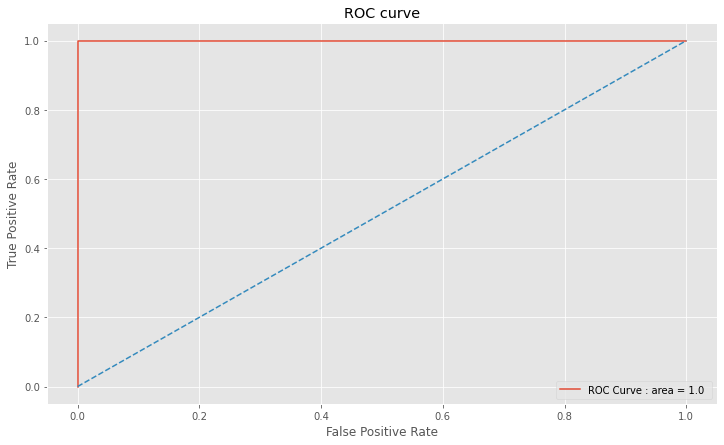

In [48]:
test_set = load_data(test_files, feature, orig_columns, segs=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# make predict use the model kept by RFECV
predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

# create confusion matrix
conf_mat = confusion_matrix(testY.astype(int), predictY.astype(int))
print(conf_mat)

# plot ROC curve for test set
fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

## 4(b) Binary Classification Using L1-penalized logistic regression

### 4(b)-i. Repeat 1(d)iii using L1-penalized logistic regression,8 i.e. instead of using p-values for variable selection, use L1 regularization.

In [49]:
# function to perform cross validation and find optimal l 
# with given classifier and specified paramter settings
def iterateLWithClf(classifier_obj, kwargs, binary_classes):
    for l in range(1, 20 + 1):
        # specify columns
        orig_columns = ['# Columns: time', 
                        'avg_rss12', 'var_rss12', 
                        'avg_rss13', 'var_rss13', 
                        'avg_rss23', 'var_rss23']
        
        statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
        feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
        
        # load data with given value of l
        train_set = load_data(train_files, feature, orig_columns, segs=l)
        test_set = load_data(test_files, feature, orig_columns, segs=l)
        
        # relabel the instance if it is binary classification
        if binary_classes:
            train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            train_set.loc[train_set['label'] != "1", 'label'] = "0"
            test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            test_set.loc[test_set['label'] != "1", 'label'] = "0"
        
        # split feature and label
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
        
        # build the classifier and fit the data
        classifier = classifier_obj(**kwargs)
        classifier.fit(trainX, trainY)
        
        # calculate the scores
        train_score = classifier.score(trainX, trainY)
        test_score = classifier.score(testX, testY)
        
        print("Value of l ~ {} : train scores {}, test score {}".format(l, 
                                                     round(train_score, 4), 
                                                     round(test_score, 4)))

        
# function to plot ROC curves
def plotROC(classifier, groudTruthY, predictY_prob, title):
    fig, axes = plt.subplots(figsize=(12, 7))
    for i, c in enumerate(classifier.classes_):
        fpr, tpr, thresholds = roc_curve(groudTruthY, predictY_prob[:, i], pos_label=c)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label="ROC Curve of {} : area = {} ".format(c, round(roc_auc, 4)))
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    axes.set_title("ROC curves of {}".format(title))
    plt.show()


def useOptimLonTest(l, classifier, kwargs, binary_classes):
    # specify columns
    orig_columns = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
    feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
    
    train_set = load_data(train_files, feature, orig_columns, segs=l)
    test_set = load_data(test_files, feature, orig_columns, segs=l)
    
    # relabel the instance if it is binary classification
    if binary_classes:
        train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        train_set.loc[train_set['label'] != "1", 'label'] = "0"
        test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        test_set.loc[test_set['label'] != "1", 'label'] = "0"
    
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # the new constructed model
    classifier = classifier(**kwargs)
    classifier.fit(trainX, trainY)
    
    # get prediction probability for both train and test, this is used to get ROC curve
    train_predictY_prob = classifier.predict_proba(trainX)
    predictY_prob = classifier.predict_proba(testX)
    
    # get prediction of test set and its confusion matrix
    predictY = classifier.predict(testX)
    conf_mat = confusion_matrix(testY, predictY)
    print("Confusion matrix on test set:\n{}".format(conf_mat))
    
    # plot ROC for multiple classes
    plotROC(classifier, trainY, train_predictY_prob, "Train Set")
    plotROC(classifier, testY, predictY_prob, "Test Set")

In [50]:
# logistic regression with L1 penalty
from sklearn.linear_model import LogisticRegressionCV

# parameter settings to create model
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

iterateLWithClf(LogisticRegressionCV, kwargs, binary_classes=True)

Value of l ~ 1 : train scores 1.0, test score 1.0
Value of l ~ 2 : train scores 1.0, test score 1.0
Value of l ~ 3 : train scores 1.0, test score 1.0
Value of l ~ 4 : train scores 1.0, test score 1.0
Value of l ~ 5 : train scores 1.0, test score 1.0
Value of l ~ 6 : train scores 1.0, test score 0.9474
Value of l ~ 7 : train scores 1.0, test score 1.0
Value of l ~ 8 : train scores 1.0, test score 1.0
Value of l ~ 9 : train scores 1.0, test score 1.0
Value of l ~ 10 : train scores 1.0, test score 1.0
Value of l ~ 11 : train scores 1.0, test score 0.9474
Value of l ~ 12 : train scores 1.0, test score 1.0
Value of l ~ 13 : train scores 1.0, test score 1.0
Value of l ~ 14 : train scores 1.0, test score 0.9474
Value of l ~ 15 : train scores 1.0, test score 0.9474
Value of l ~ 16 : train scores 1.0, test score 0.9474
Value of l ~ 17 : train scores 1.0, test score 0.9474
Value of l ~ 18 : train scores 1.0, test score 0.9474
Value of l ~ 19 : train scores 1.0, test score 1.0
Value of l ~ 20 : t

Confusion matrix on test set:
[[15  0]
 [ 0  4]]


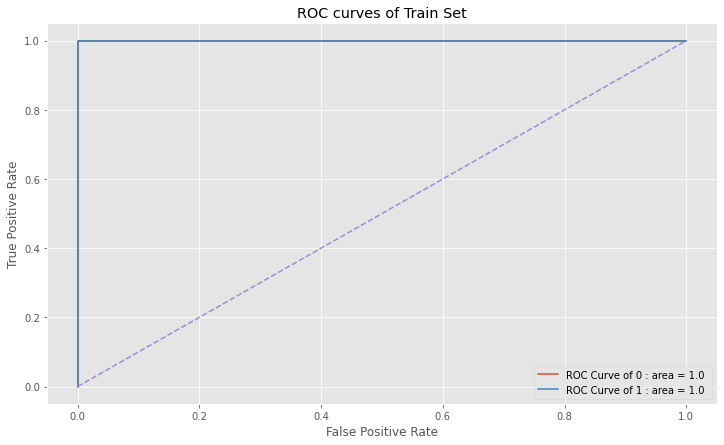

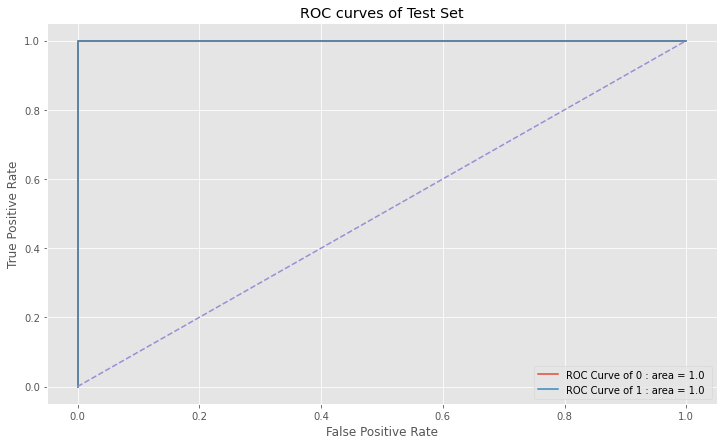

In [51]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

useOptimLonTest(1, LogisticRegression, kwargs, binary_classes=True)

## 4(b)-ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

From the results, we can see that the L1-penalized model has a better performance on cross validation and a pretty good score (1.0 accuracy) for test set as well.
The L1-regularization should be easier for implementation because we do not need to mannually select the features after an intensive computing of p-values. 

## 4(c). Multi-class Classification
### 4(c)-i. Find the best l in the same way as you found it in 1(e)i to build an L1- penalized multinomial regression model to classify all activities in your training set cross-validation for λ automatically.

In [52]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class' : 'multinomial',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'saga'
}

iterateLWithClf(LogisticRegressionCV, kwargs, binary_classes=False)

Value of l ~ 1 : train scores 0.9565, test score 0.8947
Value of l ~ 2 : train scores 1.0, test score 0.9474
Value of l ~ 3 : train scores 1.0, test score 0.8947
Value of l ~ 4 : train scores 1.0, test score 0.8947
Value of l ~ 5 : train scores 1.0, test score 0.8421
Value of l ~ 6 : train scores 1.0, test score 0.7895
Value of l ~ 7 : train scores 1.0, test score 0.7368
Value of l ~ 8 : train scores 1.0, test score 0.7895
Value of l ~ 9 : train scores 1.0, test score 0.7895
Value of l ~ 10 : train scores 1.0, test score 0.8421
Value of l ~ 11 : train scores 1.0, test score 0.8421
Value of l ~ 12 : train scores 1.0, test score 0.7895
Value of l ~ 13 : train scores 1.0, test score 0.7895
Value of l ~ 14 : train scores 1.0, test score 0.8421
Value of l ~ 15 : train scores 1.0, test score 0.7895
Value of l ~ 16 : train scores 1.0, test score 0.7895
Value of l ~ 17 : train scores 1.0, test score 0.7895
Value of l ~ 18 : train scores 1.0, test score 0.7895
Value of l ~ 19 : train scores 1.0

We choose  as the best option as it has the highest test score.

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


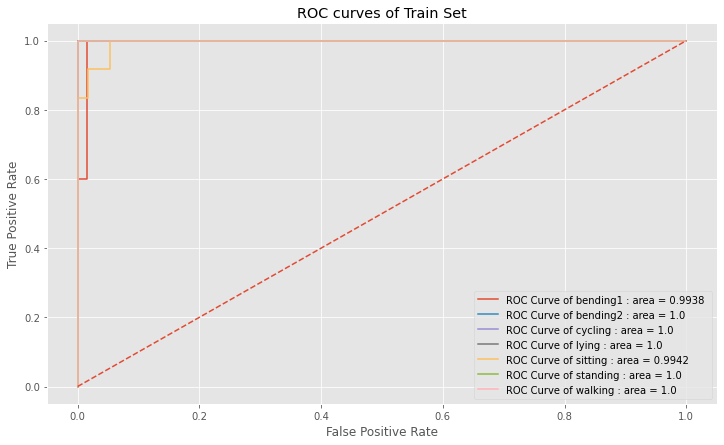

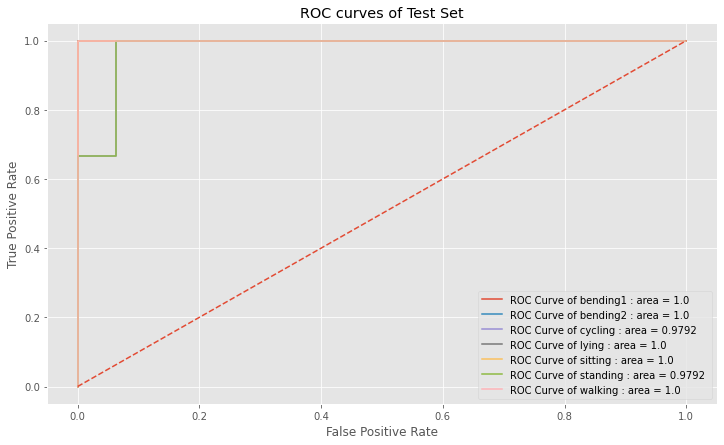

In [53]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial', 
    'solver' : 'saga'
}

useOptimLonTest(2, LogisticRegression, kwargs, binary_classes=False)

### 4(c)-ii. Repeat 1(f)i using a Naive Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

### 4(c)iii. Create p Principal Components from features extracted from features you extracted from l time series. Cross validate on the (l, p) pair to build a Na¨ıve Bayes’ classifier based on the PCA features to classify all activities in your data set. Report your test error and plot the scatterplot of the classes in your training data based on the first and second principal components you found from features extracted from l time series, where l is the value you found using cross-validation. Show confusion matrices and ROC curves.

In [54]:
from sklearn.naive_bayes import GaussianNB

iterateLWithClf(GaussianNB, {}, binary_classes=False)

Value of l ~ 1 : train scores 1.0, test score 0.8947
Value of l ~ 2 : train scores 1.0, test score 0.6316
Value of l ~ 3 : train scores 0.9855, test score 0.7368
Value of l ~ 4 : train scores 1.0, test score 0.7895
Value of l ~ 5 : train scores 0.9855, test score 0.7895
Value of l ~ 6 : train scores 0.971, test score 0.6316
Value of l ~ 7 : train scores 1.0, test score 0.7368
Value of l ~ 8 : train scores 0.9855, test score 0.7368
Value of l ~ 9 : train scores 1.0, test score 0.6842
Value of l ~ 10 : train scores 1.0, test score 0.7895
Value of l ~ 11 : train scores 0.9855, test score 0.6842
Value of l ~ 12 : train scores 1.0, test score 0.6316
Value of l ~ 13 : train scores 1.0, test score 0.7368
Value of l ~ 14 : train scores 1.0, test score 0.5789
Value of l ~ 15 : train scores 1.0, test score 0.5789
Value of l ~ 16 : train scores 1.0, test score 0.5263
Value of l ~ 17 : train scores 1.0, test score 0.5263
Value of l ~ 18 : train scores 1.0, test score 0.6842
Value of l ~ 19 : train

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


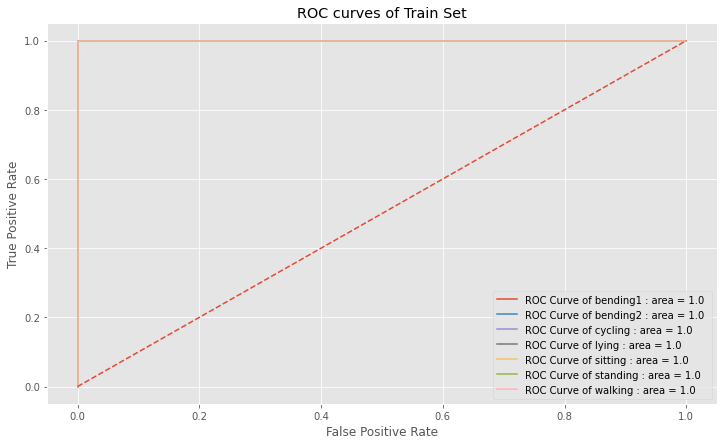

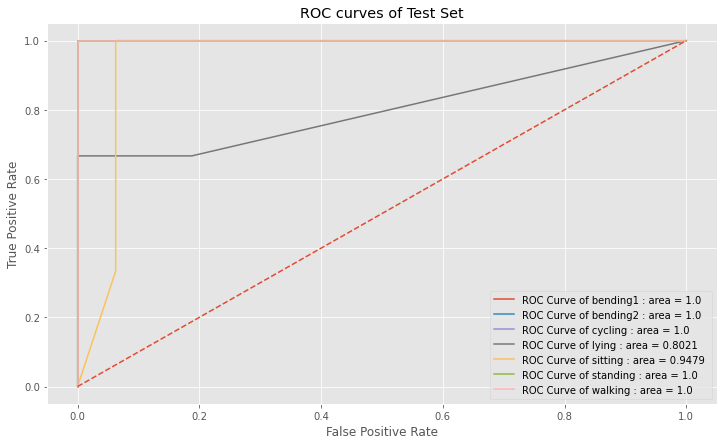

In [55]:
useOptimLonTest(1, GaussianNB, {}, binary_classes=False)

In [56]:
from sklearn.naive_bayes import MultinomialNB

iterateLWithClf(MultinomialNB, {}, binary_classes=False)

Value of l ~ 1 : train scores 0.9275, test score 0.8947
Value of l ~ 2 : train scores 0.8841, test score 0.7895
Value of l ~ 3 : train scores 0.8986, test score 0.7895
Value of l ~ 4 : train scores 0.913, test score 0.7895
Value of l ~ 5 : train scores 0.9275, test score 0.7895
Value of l ~ 6 : train scores 0.9565, test score 0.7895
Value of l ~ 7 : train scores 0.942, test score 0.7368
Value of l ~ 8 : train scores 0.942, test score 0.7895
Value of l ~ 9 : train scores 0.942, test score 0.7895
Value of l ~ 10 : train scores 0.942, test score 0.7895
Value of l ~ 11 : train scores 0.942, test score 0.7895
Value of l ~ 12 : train scores 0.942, test score 0.7895
Value of l ~ 13 : train scores 0.942, test score 0.8421
Value of l ~ 14 : train scores 0.942, test score 0.7895
Value of l ~ 15 : train scores 0.942, test score 0.8421
Value of l ~ 16 : train scores 0.942, test score 0.8421
Value of l ~ 17 : train scores 0.942, test score 0.8947
Value of l ~ 18 : train scores 0.942, test score 0.8

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]


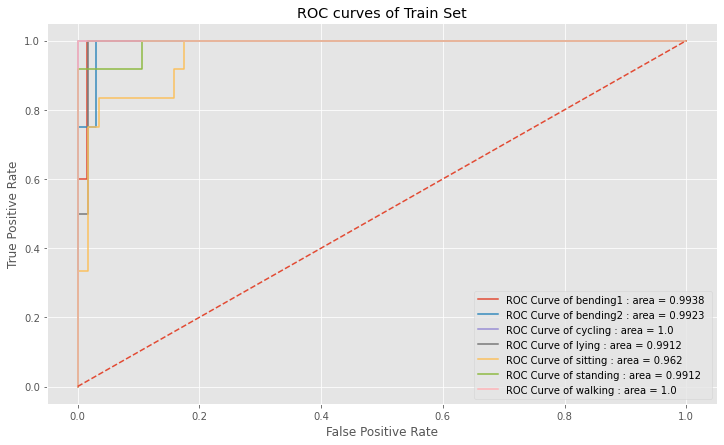

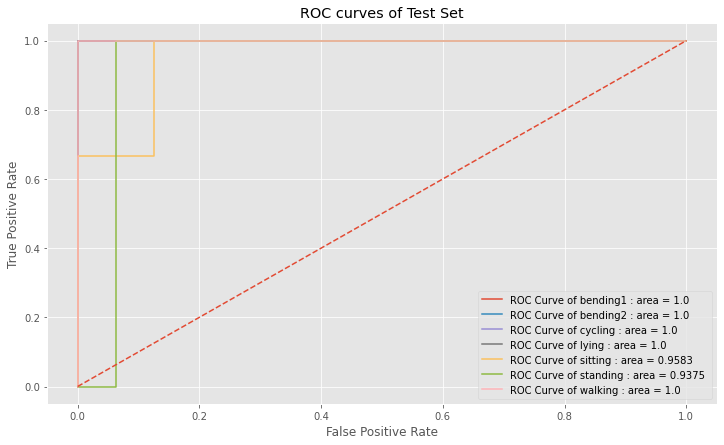

In [57]:
useOptimLonTest(1, MultinomialNB, {}, binary_classes=False)

## 4(c)-iv Which method is better for multi-class classification in this problem?
Ans: From the reported results above, we can see that the logistic regression has a better ROC curves whose AUC are larger for all classes. That means the logistic regression must have the better classification performance for this dataset.